# Projet 10 : Programme de détection des faux billets 

## Import des données et librairies nécessaires 

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from dateutil.parser import parse
from datetime import datetime
from scipy.stats import spearmanr
import scipy.stats as st
from scipy.cluster.hierarchy import dendrogram, linkage
import sklearn
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [2]:
d_billet = pd.read_csv("billets.csv", sep=";")

In [3]:
d_billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [4]:
d_billet.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
5,True,172.17,103.74,104.08,4.42,2.95,112.81
6,True,172.34,104.18,103.85,4.58,3.26,112.81
7,True,171.88,103.76,104.08,3.98,2.92,113.08
8,True,172.47,103.92,103.67,4.00,3.25,112.85
9,True,172.47,104.07,104.02,4.04,3.25,113.45


In [5]:
d_billet.describe(include="all")

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


## Première vision des variables 

### Format du df et variables 

- Le df est au format 1500x6
- 6 colonnes : 1 booléen, 5 float.
- Chaque ligne représente 1 individu, ici un billet
- Les 5 colonnes au format float caractérisent le billet via ses dimensions (diagonal, hauteur_gauche, hauteur_droite, marge_basse, marge_haut, longueur


### Valeurs manquantes et outliers 

- A priori, il n'apparait pas de valeurs abérentes qu'il faudrait retirer du df 
- Pas de valeur manquantes pour 5 des 6 variables 
- Attention, "margin_low" comprend 37 valeurs manquantes (1463 valeurs sur les 1500 attendues), soit 2% (voir missing_rate). 

In [6]:
missing_rate = d_billet.isna().sum()/d_billet.shape[0]
missing_rate

is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      0.024667
margin_up       0.000000
length          0.000000
dtype: float64

# Analyse descriptive des billets

## Pairplot

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


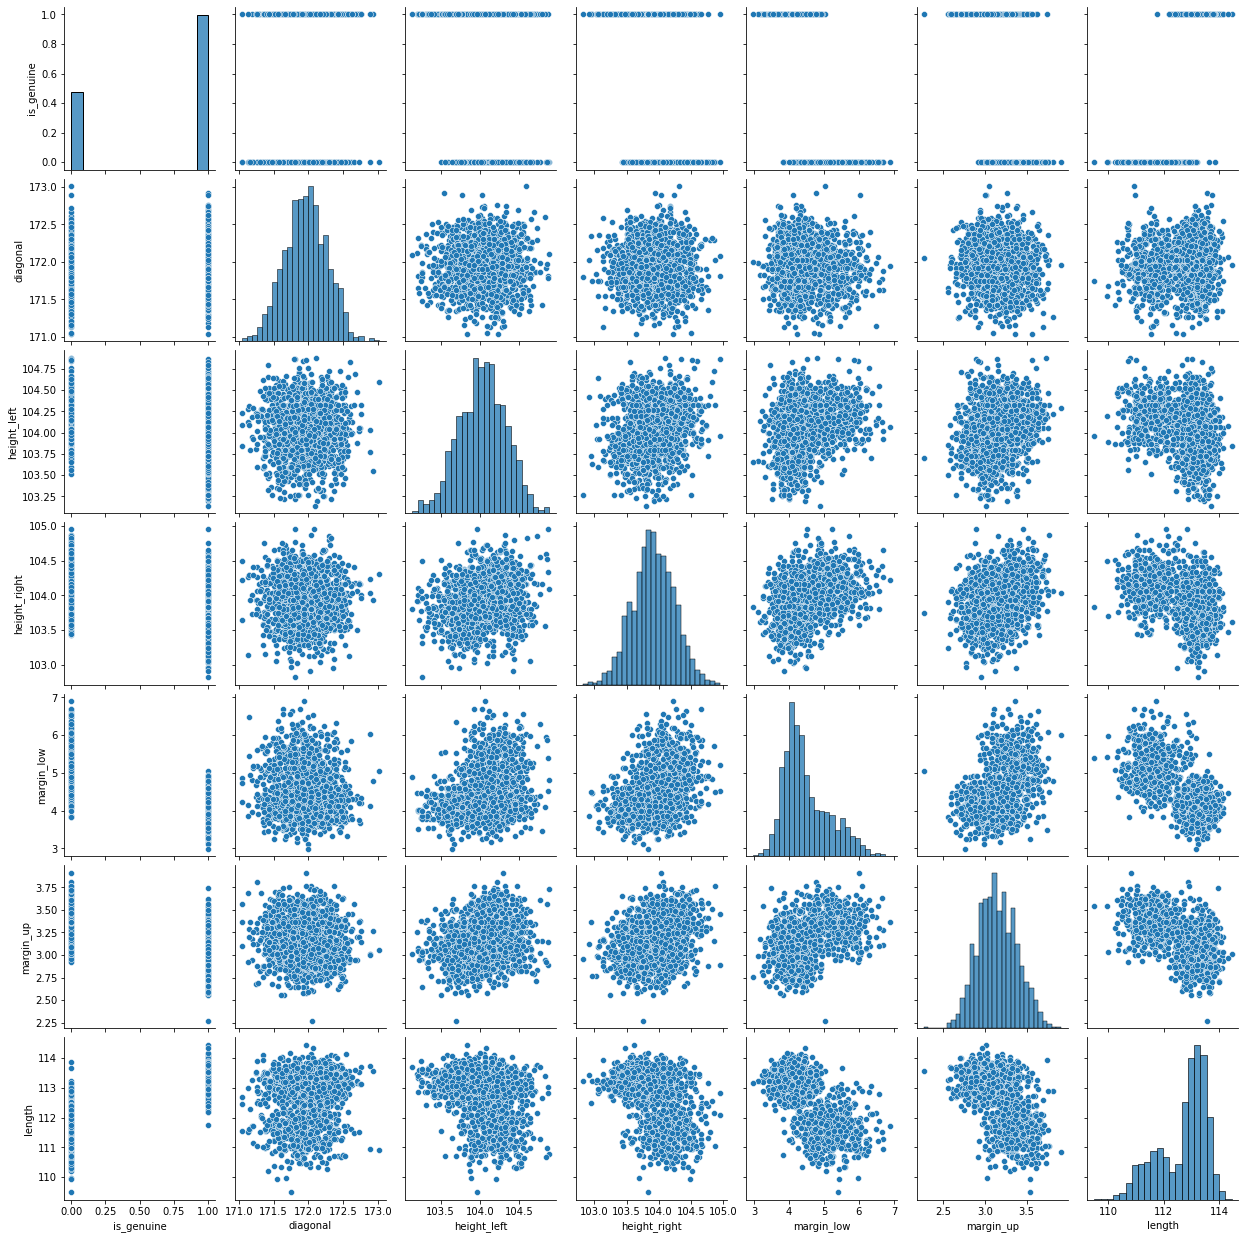

In [7]:
sns.pairplot(data=d_billet)

Le pairplot de seaborn permet de rendre compte de la distribution des variables ainsi que des éventuelles corrélations entre elles lorsqu'elles sont prises deux à deux. 

Ici, il n'apparait pas visuellement de liens entre les variables. 


## Fonction pour générer des histogrammes 

In [8]:
def histo_var(df): 

    variable = df.columns[1:]

    for x in variable : 
        plt.figure(figsize=(16,9))
        plt.plot()
        d_billet[x].hist()
        plt.xlabel(x, fontsize = 15)
        plt.ylabel("Distribution", fontsize=15)
        plt.show()


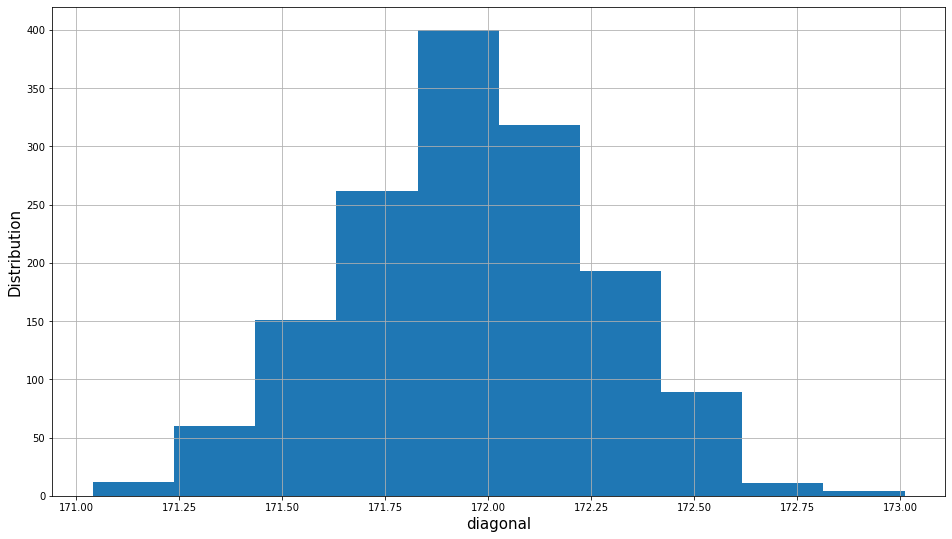

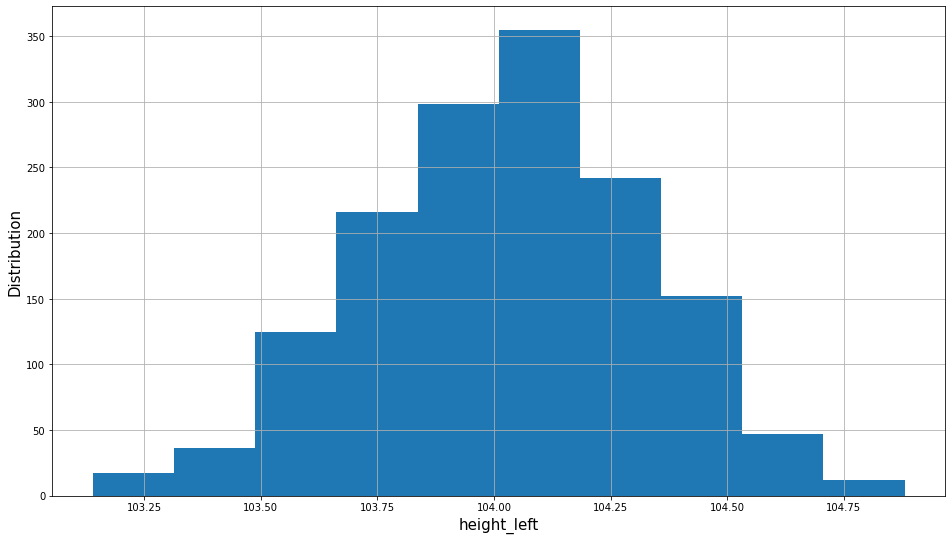

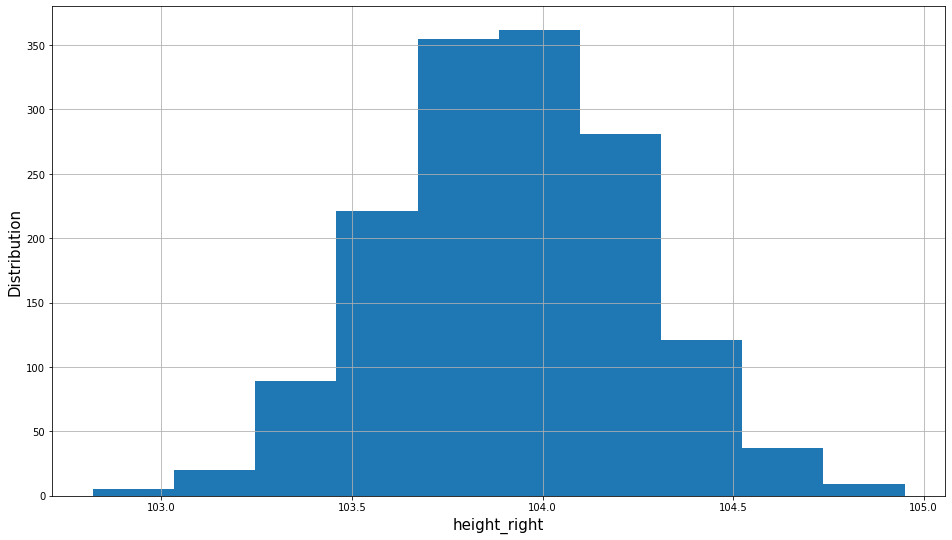

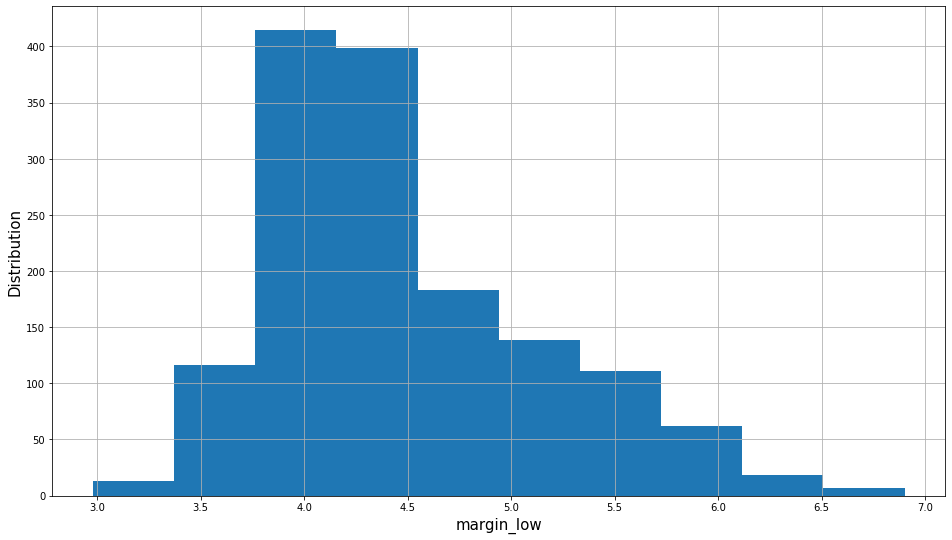

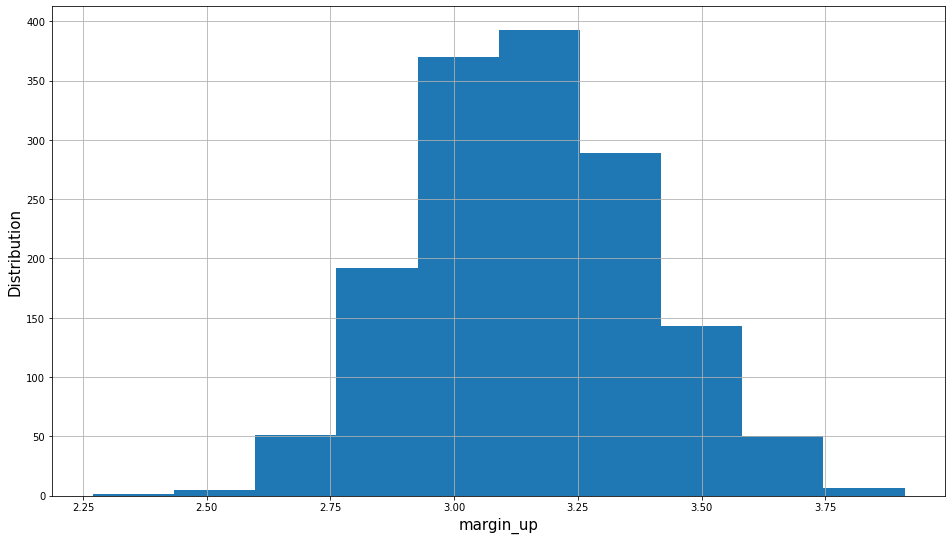

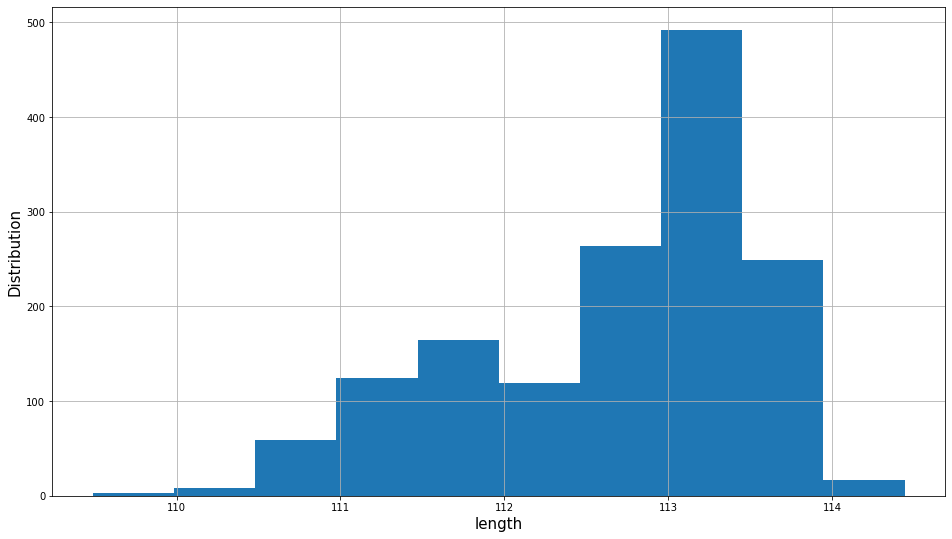

In [9]:
histo_var(d_billet)

## Compte du type de billet

In [10]:
d_billet["is_genuine"].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [11]:
billet_v_f = d_billet.pivot_table(index=["is_genuine"], aggfunc='mean')
billet_v_f


,diagonal,height_left,height_right,length,margin_low,margin_up
is_genuine,,,,,,
False,171.90116,104.19034,104.14362,111.63064,5.215935,3.35016
True,171.98708,103.94913,103.80865,113.20243,4.116097,3.05213


Ici, on a les valeurs moyennes des dimension des billets selon qu'ils soient vrais ou faux.

### On cherche à visualiser les caractéristiques des billets selon qu'ils soient vrais ou faux

Utilisation de seaborn

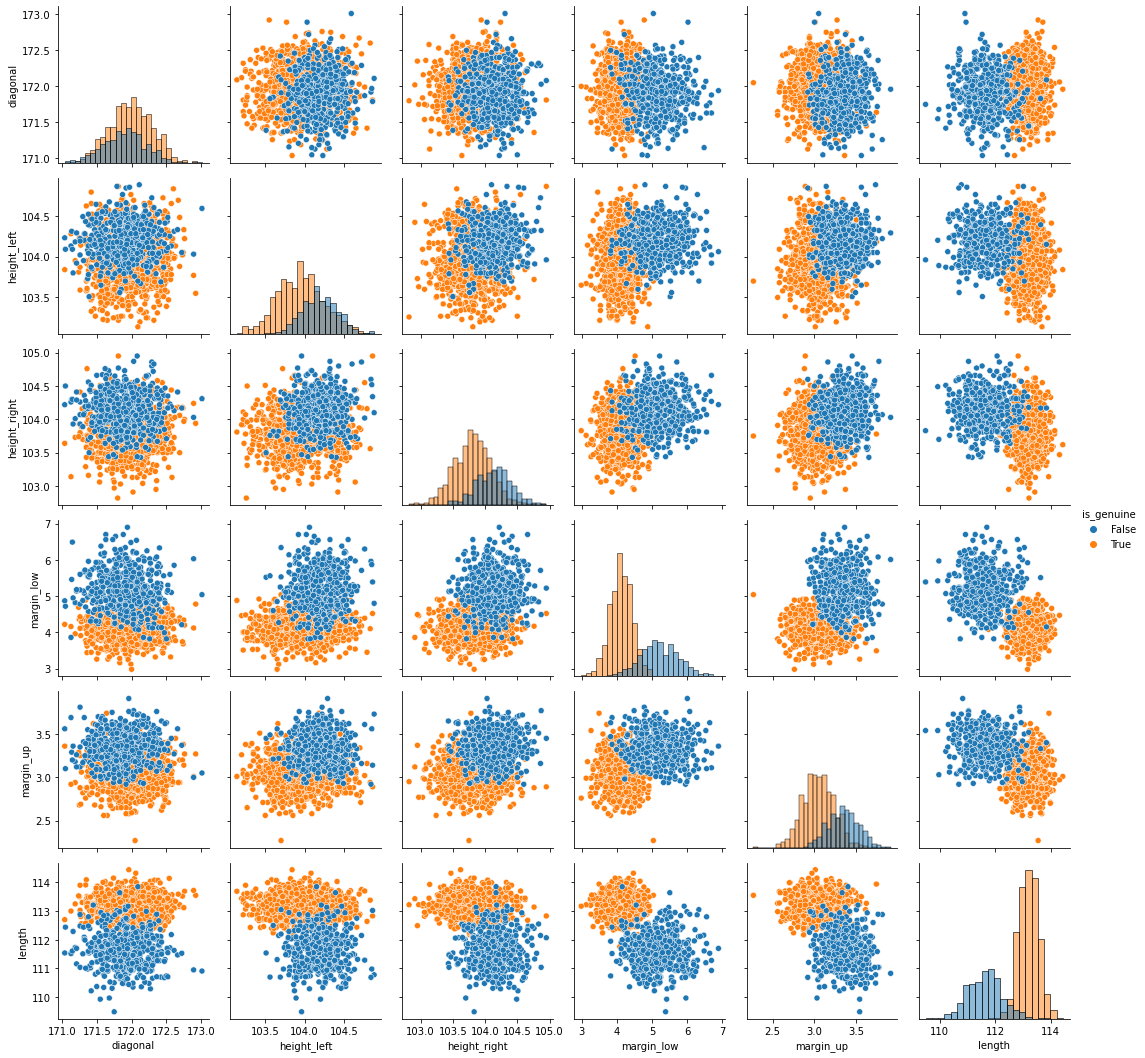

In [12]:
g = sns.PairGrid(d_billet, hue="is_genuine")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

#### On cherche à voir si des caractéristiques différencient nos billets selon le fait qu'ils soient vrai ou non

Je génère des distplots avec seaborn pour ce faire.
En réalité c'est un zoom des graphiques en diagonale de la figure précédente

In [13]:
billet_vrai = d_billet[d_billet['is_genuine'] == True]
billet_faux = d_billet[d_billet['is_genuine'] == False]

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

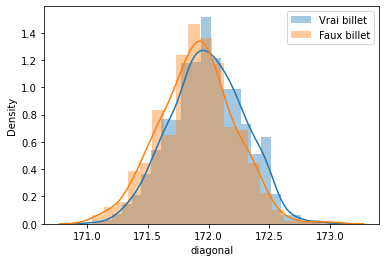

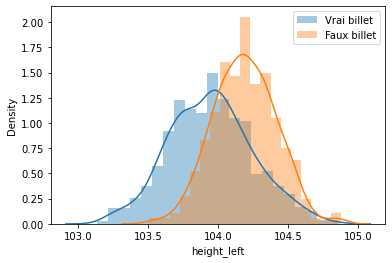

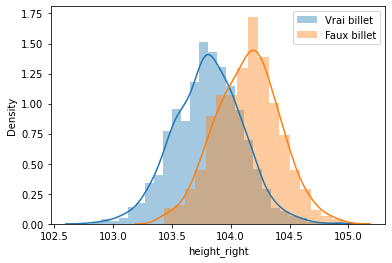

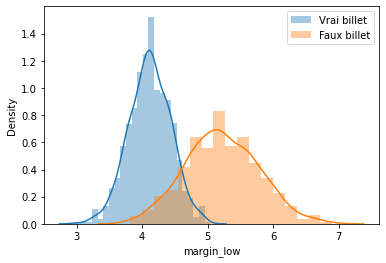

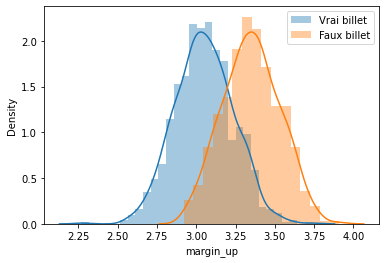

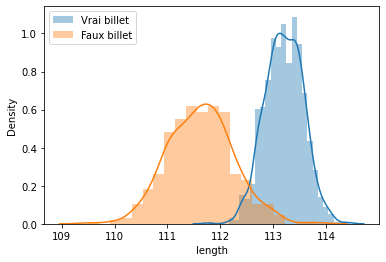

In [14]:
for col in d_billet.columns[1:] :
    plt.figure()
    sns.distplot(billet_vrai[col], label="Vrai billet")
    sns.distplot(billet_faux[col], label="Faux billet")
    plt.legend()

Des différences apparaissent particulièrement pour les variables suivantes : 

    - height_left
    - height_right
    - margin_low (++)
    - margin_up
    - lenght (++)
    
On va chercher à tester si ces différences sont significatives via un test de Student(comparaison des moyennes des distributions)

## Test de Student 

On cherche à voir si les billets vrais et faux ont des hauteurs gauche et droite, marge basse et haute et des longueurs significativement différentes

### Hypothèse nulle, H0 :

H0 = Les caractéristiques moyennes sont EGALES chez les billets vrais comme faux



In [15]:
from scipy.stats import ttest_ind

Il est préférable d'avoir des classes balancées pour réaliser le test de student. 
On va échantilloner nos df billet_vrai et billet_faux de manière à avoir le même nombre d'individus dans chacun d'eux.

In [16]:
billet_vrai.shape

(1000, 7)

In [17]:
billet_faux.shape

(500, 7)

In [18]:
billet_vrai.sample(1000)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
714,True,172.03,104.69,103.87,4.17,2.79,112.85
289,True,172.08,104.40,103.94,4.22,2.97,113.08
870,True,172.14,104.34,103.98,3.84,2.98,113.05
502,True,171.70,103.79,103.98,4.44,3.03,113.94
55,True,171.56,103.42,103.64,3.77,3.04,113.30
...,...,...,...,...,...,...,...
735,True,171.92,103.93,104.06,4.38,2.97,113.01
37,True,171.73,104.10,104.19,3.39,3.19,112.79
284,True,171.92,103.83,103.76,NaN,3.23,113.29
916,True,171.64,103.90,104.07,3.60,3.39,113.18


In [19]:
balanced_vrai = billet_vrai.sample(billet_faux.shape[0])

In [20]:
def t_test(col) :
    alpha = 0.02
    stat, p = ttest_ind(balanced_vrai[col].dropna(), billet_faux[col].dropna())
    if p < alpha:
        return p, "H0 rejetée"
    else :
        return "0"
    

In [21]:
for col in d_billet.columns[1:]:
    print(col)
    print('p_value', t_test(col))
    print("_______")
    print()

diagonal
p_value (0.00013461864901124395, 'H0 rejetée')
_______

height_left
p_value (2.973834013044278e-41, 'H0 rejetée')
_______

height_right
p_value (1.8663923703949505e-68, 'H0 rejetée')
_______

margin_low
p_value (1.468486631597968e-190, 'H0 rejetée')
_______

margin_up
p_value (1.3822940942070824e-109, 'H0 rejetée')
_______

length
p_value (2.6559691178119064e-271, 'H0 rejetée')
_______



On peut considérer avec peu de chances de se tromper qu'il existe bel et bien une différence entre les vrais billets et les faux billets selon les variables de dimensions qui les caractérisent.

## Remplacement des valeurs manquantes pour la variable margin_low

On cherche à voir s'il est possible d'exprimer la varaible margin_low en fonction d'une autre. 


In [22]:
d_full = d_billet.dropna(inplace=False)
mat_corr = d_full.corr()
mat_corr

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.134720,-0.373624,-0.487177,-0.783032,-0.610412,0.850223
diagonal,0.134720,1.000000,0.018265,-0.019428,-0.111534,-0.059147,0.100758
height_left,-0.373624,0.018265,1.000000,0.235132,0.302643,0.243812,-0.314344
height_right,-0.487177,-0.019428,0.235132,1.000000,0.391085,0.306867,-0.404272
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.610412,-0.059147,0.243812,0.306867,0.431606,1.000000,-0.521139
length,0.850223,0.100758,-0.314344,-0.404272,-0.666753,-0.521139,1.000000


<AxesSubplot:>

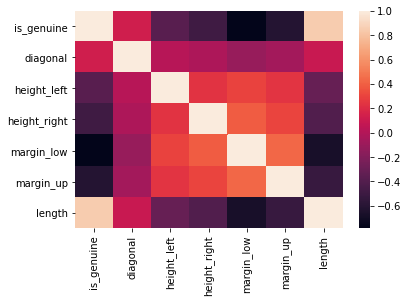

In [23]:
sns.heatmap(data=mat_corr)

# Remplacement des valeurs manquantes

In [24]:
## Il ne faut pas utiliser la valeur is_genuine

On sépare les valeurs manquantes et on les considère comme le df de test

In [25]:
test_data = d_billet[d_billet["margin_low"].isnull()]
test_data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


On enlève les valeurs manquantes de d_billet et on considère ce nouveau df comme le train dataset

In [26]:
d_billet.dropna(inplace = True)

In [27]:
d_billet.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [28]:
d_billet.shape

(1463, 7)

on crée X_train et y_train depuis d_billet

In [29]:
y_train = d_billet['margin_low']
y_train.isnull().sum()

0

In [30]:
y_train.shape

(1463,)

In [31]:
X_train = d_billet.drop(['margin_low','is_genuine'], axis=1)
X_train.shape

(1463, 5)

In [32]:
from sklearn.linear_model import LinearRegression

model_l = LinearRegression()
model_l.fit(X_train, y_train)


LinearRegression()

Création du test dataset

In [33]:
X_test = test_data.drop(['margin_low','is_genuine'], axis=1)

In [34]:
X_test.head()

,diagonal,height_left,height_right,margin_up,length
72,171.94,103.89,103.45,3.25,112.79
99,171.93,104.07,104.18,3.14,113.08
151,172.07,103.80,104.38,3.02,112.93
197,171.45,103.66,103.80,3.62,113.27
241,171.83,104.14,104.06,3.02,112.36


In [35]:
X_test.shape

(37, 5)

Application du modèle sur le test set et prédiction des valeurs manquantes 

In [36]:
y_pred = model_l.predict(X_test)


In [37]:
model_l.score(X_train, y_train)


0.4773366973063954

On ajoute les résultats de la régression pour les valeurs manquantes dans le test_data

In [38]:
test_data.loc[test_data.margin_low.isnull(), 'margin_low'] = y_pred

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [39]:
y_pred

array([4.31852466, 4.39366755, 4.41045663, 4.31901423, 4.6506171 ,
       3.80330831, 4.17973608, 4.12744154, 4.13503418, 4.16053851,
       4.17742026, 3.76855378, 4.05876385, 4.29804709, 4.16060746,
       4.09406453, 4.43984627, 4.47065037, 4.34164322, 4.08041448,
       3.61430588, 4.37181147, 4.09362068, 4.24962896, 3.89374829,
       3.74633265, 4.23741481, 4.71053287, 4.13778022, 5.05027715,
       4.80214523, 5.067584  , 5.04756967, 4.77896717, 5.726993  ,
       5.18586214, 5.14004269])

In [40]:
test_data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.318525,3.25,112.79
99,True,171.93,104.07,104.18,4.393668,3.14,113.08
151,True,172.07,103.80,104.38,4.410457,3.02,112.93
197,True,171.45,103.66,103.80,4.319014,3.62,113.27
241,True,171.83,104.14,104.06,4.650617,3.02,112.36
251,True,171.80,103.26,102.82,3.803308,2.95,113.22
284,True,171.92,103.83,103.76,4.179736,3.23,113.29
334,True,171.85,103.70,103.96,4.127442,3.00,113.36
410,True,172.56,103.72,103.51,4.135034,3.12,112.95
413,True,172.30,103.66,103.50,4.160539,3.16,112.95


Concaténation du d_billet et du test_data afin d'obtenir le dataframe final

In [41]:
df = pd.concat([d_billet,test_data])

In [42]:
df.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [43]:
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.047570,2.93,111.21
1315,False,172.08,104.15,104.17,4.778967,3.40,112.29
1347,False,171.72,104.46,104.12,5.726993,3.61,110.31
1435,False,172.66,104.33,104.41,5.185862,3.56,111.47


# Mise en place du K-means

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import decomposition

# Nombre de clusters souhaités
n_clust = 2

# import de l'échantillon
data =df[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]

# préparation des données pour le clustering
X = data.values

# Les variables sont ici centrée réduites

X = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)



# Récupération des clusters attribués à chaque individu
clusters = km.labels_


In [45]:
df['cluster']= clusters


In [46]:
df['is_genuine'].replace([True,False],[0,1],inplace =True)
df['cluster'].replace([1,0],[0,1],inplace = True)
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,0,171.81,104.86,104.95,4.520000,2.89,112.83,1
1,0,171.46,103.36,103.66,3.770000,2.99,113.09,0
2,0,172.69,104.48,103.50,4.400000,2.94,113.16,0
3,0,171.36,103.91,103.94,3.620000,3.01,113.51,0
4,0,171.73,104.28,103.46,4.040000,3.48,112.54,0
...,...,...,...,...,...,...,...,...
1303,1,172.17,104.49,103.76,5.047570,2.93,111.21,1
1315,1,172.08,104.15,104.17,4.778967,3.40,112.29,1
1347,1,171.72,104.46,104.12,5.726993,3.61,110.31,1
1435,1,172.66,104.33,104.41,5.185862,3.56,111.47,1


Je génère la matrice de confusion, ici je le fais avec la fonction confusion_matrix de la librairie sklearn

In [47]:
from sklearn.metrics import confusion_matrix

y_actu = df['is_genuine']
y_pred = df['cluster']

confusion_matrix(y_actu, y_pred)

array([[990,  10],
       [ 13, 487]])

Je génère la matrice de confusion, ici je génère un dataframe en %

In [48]:
y_actu = pd.Series(df['is_genuine'], name='Actual')
y_pred = pd.Series(df['cluster'], name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, normalize="index")
df_confusion

Predicted,0,1
Actual,,
0,0.990,0.010
1,0.026,0.974


### Interprétation de la matrice de confusion.

Permet d'obtenir des renseignements sur les performances du modèle
Revoir en fonction des metrics de sklearn

En l'epèce on obtient : 

- Parmi les 1000 vrais billets :
    - 998 ont été bien placés (recall) 
    - 2 ont été prédis comme étant faux alors qu'ils étaient vrai (faux négatifs)
    
- Parmi les 500 faux billets :
    - 481 sont biens placés  
    - 19 sont prédis comme étant vrais alors qu'ils sont faux en réalité (faux positifs)

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_actu,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.97      0.98       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



# Regression Logistique 

In [50]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [51]:
df_l = df.drop("cluster", axis=1)

In [52]:
from sklearn.model_selection import train_test_split

X = df_l.drop(['is_genuine'], axis=1)
y = df_l['is_genuine']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=2)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [53]:
y_predicted = model.predict(X_test)
model.predict_proba(X_test)

array([[9.93364682e-01, 6.63531800e-03],
       [9.40211698e-03, 9.90597883e-01],
       [5.24444866e-03, 9.94755551e-01],
       [9.95900696e-01, 4.09930365e-03],
       [9.99738046e-01, 2.61954197e-04],
       [9.99450489e-01, 5.49510975e-04],
       [9.81325486e-01, 1.86745140e-02],
       [9.99851988e-01, 1.48011669e-04],
       [9.99929558e-01, 7.04416890e-05],
       [8.30624003e-05, 9.99916938e-01],
       [1.81727251e-03, 9.98182727e-01],
       [9.94583760e-01, 5.41623962e-03],
       [5.87923033e-03, 9.94120770e-01],
       [9.94917089e-01, 5.08291050e-03],
       [9.90924743e-01, 9.07525746e-03],
       [9.99868767e-01, 1.31232881e-04],
       [1.34573175e-04, 9.99865427e-01],
       [9.97207530e-01, 2.79247036e-03],
       [2.13156108e-02, 9.78684389e-01],
       [9.92499775e-01, 7.50022535e-03],
       [9.96908591e-01, 3.09140930e-03],
       [2.49164827e-06, 9.99997508e-01],
       [9.99895937e-01, 1.04062514e-04],
       [8.15584292e-04, 9.99184416e-01],
       [3.451197

In [54]:
probabilites = model.predict_proba(X)


In [55]:
df_l['prediction']=model.predict(X)

In [56]:
from sklearn.metrics import accuracy_score
model_acc = accuracy_score(df_l['is_genuine'],df_l['prediction'])
model_acc

0.988

In [57]:
print('Train_score', model.score(X_train,y_train))
print('Test_score', model.score(X_test,y_test))

Train_score 0.9875
Test_score 0.99


In [58]:
conf_mat = pd.crosstab(df_l['is_genuine'],df_l['prediction'])
conf_mat

prediction,0,1
is_genuine,,
0,994,6
1,12,488


In [59]:
vrai_negatif = conf_mat.loc[0,0]
faux_positif = conf_mat.loc[0,1]
faux_negatif = conf_mat.loc[1,0]
vrai_positif = conf_mat.loc[1,1]

taux_erreur = (faux_positif + faux_negatif) / (vrai_negatif+faux_positif+faux_negatif+vrai_positif)
taux_erreur

0.012

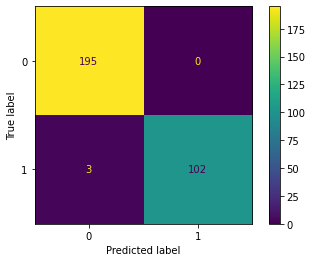

In [60]:
from sklearn import metrics
metrics.plot_confusion_matrix(model,X_test,y_test)

# Régression logistique avec la Cross-Validation 

In [61]:
from sklearn.linear_model import LogisticRegressionCV

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=2)

model_CV = LogisticRegressionCV()
model_CV.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegressionCV()

In [62]:
y_predicted = model_CV.predict(X_test)
model_CV.predict_proba(X_test)

array([[9.99175331e-01, 8.24668839e-04],
       [3.14008603e-04, 9.99685991e-01],
       [4.58681339e-04, 9.99541319e-01],
       [9.99835112e-01, 1.64888251e-04],
       [9.99996757e-01, 3.24287277e-06],
       [9.99986916e-01, 1.30838185e-05],
       [9.92113773e-01, 7.88622679e-03],
       [9.99999672e-01, 3.27842285e-07],
       [9.99999582e-01, 4.18338638e-07],
       [2.96072797e-07, 9.99999704e-01],
       [1.82479623e-05, 9.99981752e-01],
       [9.99752737e-01, 2.47263002e-04],
       [2.08072882e-04, 9.99791927e-01],
       [9.99589518e-01, 4.10481976e-04],
       [9.99468335e-01, 5.31664942e-04],
       [9.99998495e-01, 1.50456110e-06],
       [3.21425277e-07, 9.99999679e-01],
       [9.99887032e-01, 1.12968397e-04],
       [1.67300806e-03, 9.98326992e-01],
       [9.99487477e-01, 5.12522834e-04],
       [9.99896088e-01, 1.03912226e-04],
       [2.65405453e-09, 9.99999997e-01],
       [9.99999066e-01, 9.34433929e-07],
       [8.61115857e-06, 9.99991389e-01],
       [1.835159

In [63]:
print('Train_score', model_CV.score(X_train,y_train))
print('Test_score', model_CV.score(X_test,y_test))

Train_score 0.99
Test_score 0.9933333333333333


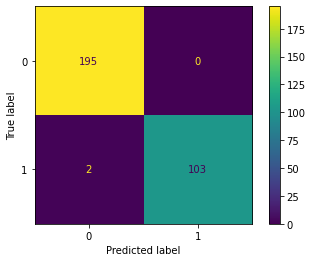

In [64]:
from sklearn import metrics
metrics.plot_confusion_matrix(model_CV,X_test,y_test)

In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       195
           1       1.00      0.98      0.99       105

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



Compte tenu des résultats des 3 modèles testés, il apparait que le modèle de régression logistique intégrant la cross-validation comprend les meilleurs résultats. 

Ce modèle sera utilisé pour tester les futurs billets. 

Pour ce faire, il convient d'enregistrer le modèle entrainé grâce à la librairie joblib.


## Enregistrement du modèle de régression logistique entrainé

In [66]:
from joblib import dump, load
dump(model_CV, "Logistic_Trained_model.joblib")

['Logistic_Trained_model.joblib']